In [7]:
# Import
from Diffusion import *
from utils import makedir
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from datetime import datetime
import h5py as h5
import pickle
import os

In [8]:
# Parameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
local_storage_dir = "/home/md775/LocalStorage/MLProjects/Diffusion/" # Change this to your storage directory
dataset_path = local_storage_dir + "Datasets/RegularTriangulations/dataset.h5"
checkpoint_dir = local_storage_dir + "Checkpoints/Triangulations/"
log_dir = local_storage_dir + "Logs/"
sample_dir = os.getcwd() + "/samples/triangulations/"
gif_dir = os.getcwd() + "/gifs/"
makedir(checkpoint_dir)
makedir(log_dir)
makedir(sample_dir)
makedir(gif_dir)
num_channels = 1 # 1 for grayscale
num_timesteps = 2000 # Number of timesteps of the diffusion process
beta_min = 1e-6
beta_max = 0.99
image_size = 8
batch_size = 2**10
max_dataset_size = -1 # Set to -1 to use the entire dataset

In [9]:
# Load dataset
class hdf5Dataset(Dataset):
    def __init__(self, dataset_path, load_all=False, transform=None):
        self.transform = transform
        self.dataset_path = dataset_path
        self.load_all = load_all
        if load_all:
            self.dataset = h5.File(dataset_path, 'r')['height_images'][:]
            self.dataset = self.dataset[:,None,:,:]
            self.dataset = torch.from_numpy(self.dataset).float()
        else:
            self.dataset = h5.File(dataset_path, 'r')['height_images']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if self.load_all:
            image = self.dataset[idx]
        else:
            image = self.dataset[idx][None,:,:]
            image = torch.from_numpy(image).float()
        if self.transform:
            image = self.transform(image)
        return image        

#transform = transforms.Resize((image_size, image_size), antialias=True)
# transform = transforms.Compose([
#     transforms.Resize((image_size, image_size), antialias=True), 
# ])
transform = transforms.Lambda(lambda t: 16*t) # Scale the images to make sure noising is not too weak or too strong

image_dataset = hdf5Dataset(dataset_path, load_all=False, transform=transform)
dataloader = DataLoader(image_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=24, pin_memory=True, persistent_workers=True)

In [10]:
# Create diffusion model
DiffusionModel = Diffusion(
    image_size=image_size,
    num_channels = num_channels,
    num_timesteps=num_timesteps,
    beta_min=beta_min,
    beta_max=beta_max,
    beta_schedule="cosine",
    batch_size=batch_size,
    device=device
)

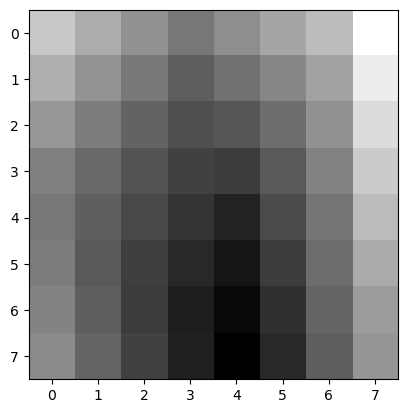

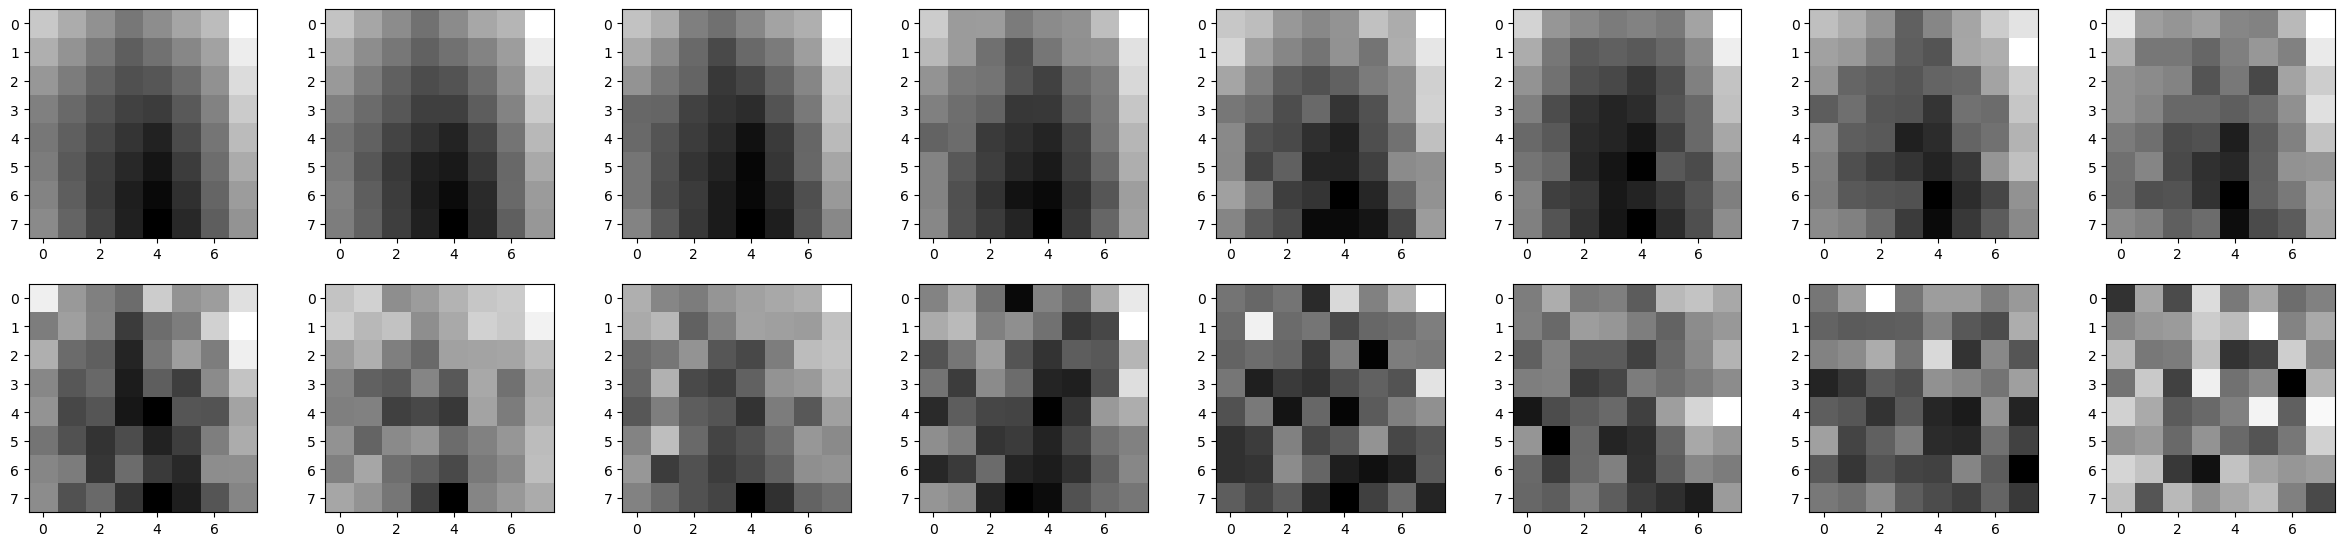

In [11]:
# Visualize forward process
def image_from_tensor(tensor):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t.cpu().numpy().astype(np.float32)),
    ])
    return reverse_transforms(tensor)

initial_tensor = next(iter(dataloader)).to(device)
plt.imshow(image_from_tensor(initial_tensor[0]), cmap='gray')

plt.figure(figsize=(30,60))
num_images = 16
stepsize = int(num_timesteps/num_images)
for idx in range(0, num_timesteps):
    if idx % stepsize == 0:
        t = torch.Tensor([idx]).type(torch.int64)
        plt.subplot(int(num_images+1/8)+1, 8, int(idx/stepsize) + 1)
        tensor, noise = DiffusionModel.forward_process(initial_tensor[0,None], t)
        plt.imshow(image_from_tensor(tensor[0]), cmap="gray")

In [35]:
# Create Unet model
model = DiffusionModel.create_model(
    num_init_ch=64,
    num_downsamples=2,
    num_mid_convs=1
    )
print("Num params: ", sum(p.numel() for p in model.parameters()))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99, last_epoch=-1, verbose=False)

Num params:  3576065


In [36]:
# Training
def loss_fn(true,pred):
    return F.mse_loss(true, pred) + F.l1_loss(true, pred)

load_from_checkpoint = False
if load_from_checkpoint:
    DiffusionModel.load_from_checkpoint(checkpoint_dir+"model_min_loss.pt", model, optimizer, lr_scheduler)
    
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
DiffusionModel.train_model(
    epochs=200,
    data_loader=dataloader,
    model=model,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    loss_function=loss_fn,
    checkpoint_dir=checkpoint_dir,
    checkpoint_interval=1,
    log_dir=log_dir+timestamp
    )

  0%|          | 0/1024 [00:00<?, ?it/s]

100%|██████████| 1024/1024 [01:13<00:00, 13.85it/s, Epoch:=1, LR:=0.001, Loss:=0.525]


Epoch: 1 Loss: 0.5253804633684922
LR: 0.00099


100%|██████████| 1024/1024 [00:24<00:00, 41.40it/s, Epoch:=2, LR:=0.00099, Loss:=0.455]


Epoch: 2 Loss: 0.4549266303947661
LR: 0.0009801


100%|██████████| 1024/1024 [00:25<00:00, 40.85it/s, Epoch:=3, LR:=0.00098, Loss:=0.434]


Epoch: 3 Loss: 0.4343906574358698
LR: 0.000970299


100%|██████████| 1024/1024 [00:24<00:00, 41.98it/s, Epoch:=4, LR:=0.00097, Loss:=0.424]


Epoch: 4 Loss: 0.42448692009202205
LR: 0.0009605960099999999


100%|██████████| 1024/1024 [00:24<00:00, 41.25it/s, Epoch:=5, LR:=0.000961, Loss:=0.418]


Epoch: 5 Loss: 0.4178735117893666
LR: 0.0009509900498999999


100%|██████████| 1024/1024 [00:24<00:00, 42.34it/s, Epoch:=6, LR:=0.000951, Loss:=0.414]


Epoch: 6 Loss: 0.41367761537549086
LR: 0.0009414801494009999


100%|██████████| 1024/1024 [00:24<00:00, 41.94it/s, Epoch:=7, LR:=0.000941, Loss:=0.411]


Epoch: 7 Loss: 0.41053817616193555
LR: 0.0009320653479069899


100%|██████████| 1024/1024 [00:25<00:00, 40.72it/s, Epoch:=8, LR:=0.000932, Loss:=0.408]


Epoch: 8 Loss: 0.40784499788424
LR: 0.00092274469442792


100%|██████████| 1024/1024 [00:25<00:00, 40.85it/s, Epoch:=9, LR:=0.000923, Loss:=0.405]


Epoch: 9 Loss: 0.40506404676125385
LR: 0.0009135172474836408


100%|██████████| 1024/1024 [00:25<00:00, 40.62it/s, Epoch:=10, LR:=0.000914, Loss:=0.403]


Epoch: 10 Loss: 0.40315411635674536
LR: 0.0009043820750088043


100%|██████████| 1024/1024 [00:24<00:00, 42.16it/s, Epoch:=11, LR:=0.000904, Loss:=0.402]


Epoch: 11 Loss: 0.4020012471592054
LR: 0.0008953382542587163


 14%|█▍        | 143/1024 [00:03<00:21, 41.40it/s, Epoch:=12, LR:=0.000895, Loss:=0.4]  


KeyboardInterrupt: 

In [37]:
# Sample from model
DiffusionModel.load_from_checkpoint(checkpoint_dir+"model_min_loss.pt", model)
tensor_sample = DiffusionModel.sample(num_images=1, variance_coeff=1.0)
tensor_sample = tensor_sample.cpu()

0it [00:00, ?it/s]

1999it [00:14, 138.27it/s]


In [38]:
# Save sample
makedir(sample_dir)
with open(sample_dir + "height_images.pkl", "wb") as f:
    pickle.dump(tensor_sample.numpy()[0], f)


In [39]:
# Create triangulations
# This requires CYTools. See https://cy.tools/ for installation instructions and more information.
! docker run --rm -it --name cytools-uid-$UID -v ./:/home/cytools/mounted_volume -p $(($UID+2875)):$(($UID+2875)) cytools:uid-$UID python3 ./cytools_triangulate.py


Info: A more recent version of CYTools is available: v1.0.11 -> v1.0.13.
We recommend upgrading before continuing.
On Linux and macOS you can update CYTools by running 'cytools --update'
and on Windows you can do this by running the updater tool.



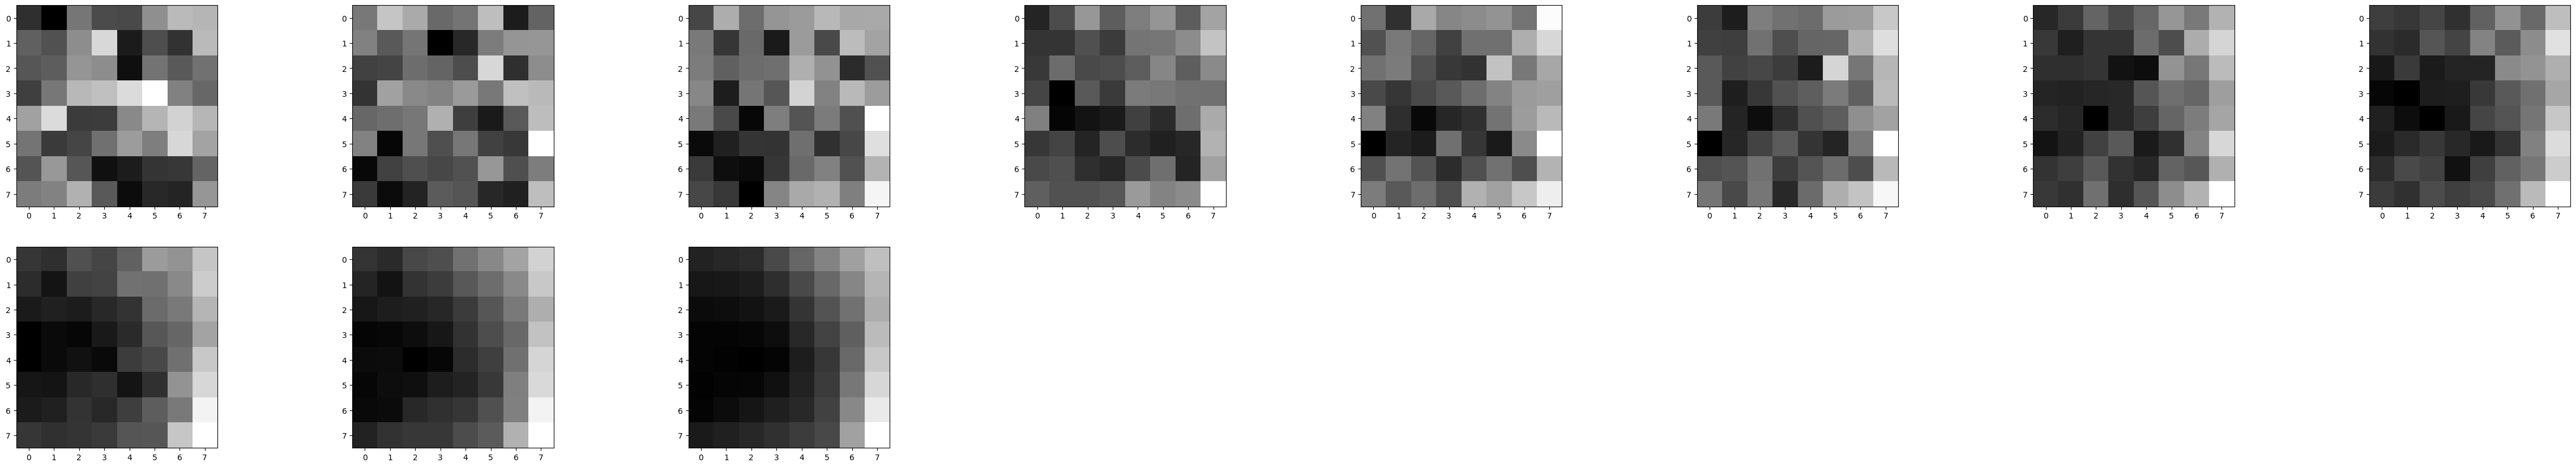

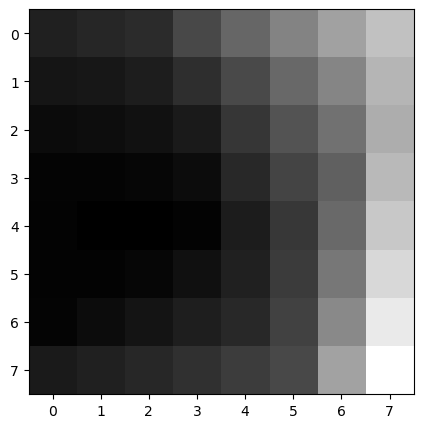

In [40]:
# VISUALIZE REVERSE PROCESS
plt.figure(figsize=(60,60))
num_step_images = 10
stepsize = int(num_timesteps/num_step_images)

tensors = tensor_sample[0]
for i, tensor in enumerate(tensors):
    if i % stepsize == 0:
        plt.subplot(int(num_step_images+1/8)+1, 8, int(i/stepsize) + 1)
        plt.imshow(image_from_tensor(tensor), cmap="gray")
plt.figure(figsize=(5,5))
plt.imshow(image_from_tensor(tensors[-1]), cmap="gray")

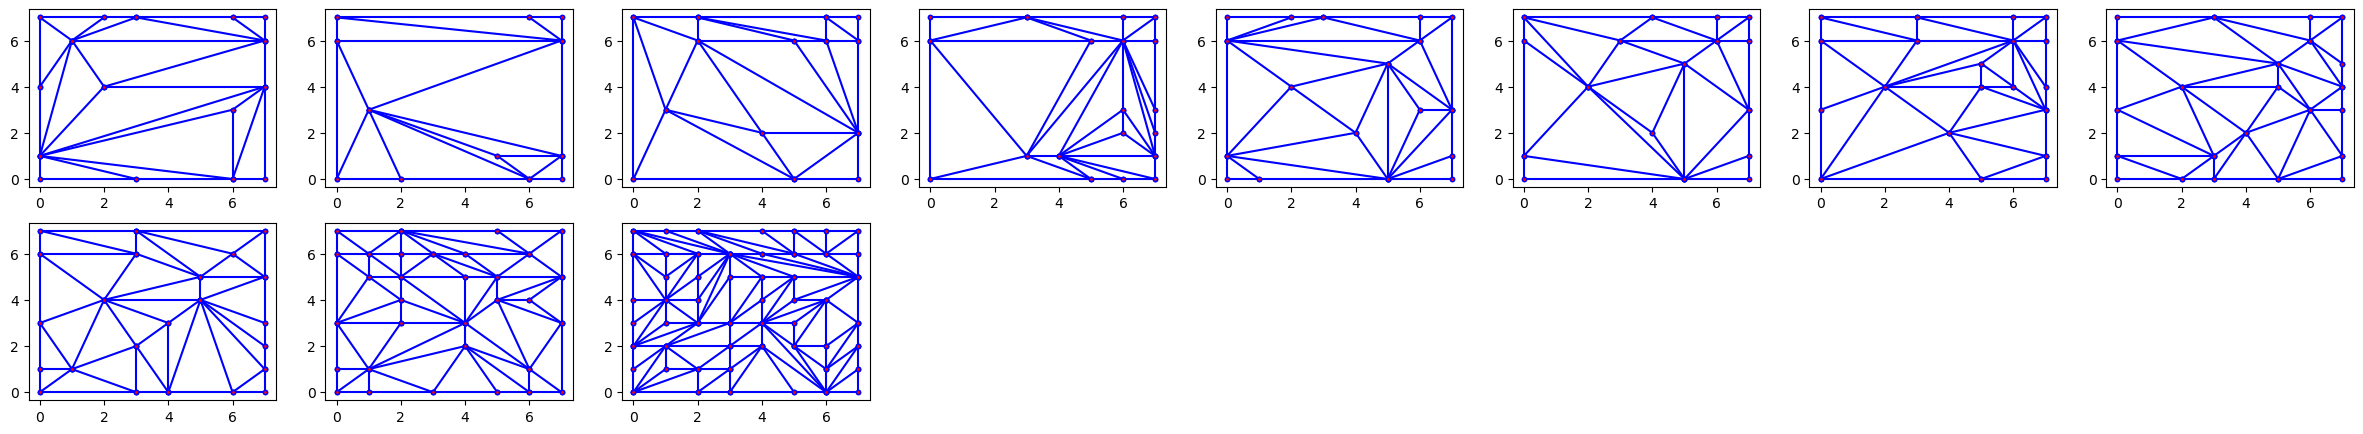

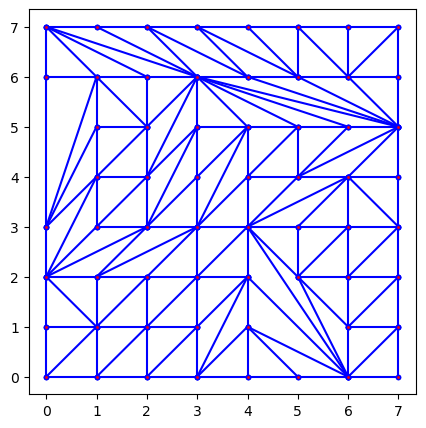

In [41]:
# Visualize triangulations

# Load triangulations
points_list = np.load(sample_dir + "points.pkl", allow_pickle=True)
simplices_list = np.load(sample_dir + "simplices.pkl", allow_pickle=True)

def Plot_2D_Triangulation(points, simplices):
    edges = np.unique(np.concatenate([((ss[0],ss[1]),(ss[0],ss[2]),(ss[1],ss[2])) for ss in simplices]),axis=0)
    x = points[:,0].flatten()
    y = points[:,1].flatten()
    return plt.plot(x[edges.T], y[edges.T], linestyle='-', color='b', markerfacecolor='red', marker='.')  
    

plt.figure(figsize=(30,30))
num_images = 10
num_timesteps = len(points_list)
stepsize = int(num_timesteps/num_images)

for idx in range(0, num_timesteps, stepsize):
    plt.subplot(int(num_images+1/8)+1, 8, int(idx/stepsize) + 1)
    Plot_2D_Triangulation(points_list[idx], simplices_list[idx])

plt.figure(figsize=(5,5))
Plot_2D_Triangulation(points_list[-1], simplices_list[-1])
plt.show()


100%|██████████| 1999/1999 [00:00<00:00, 156615.55it/s]


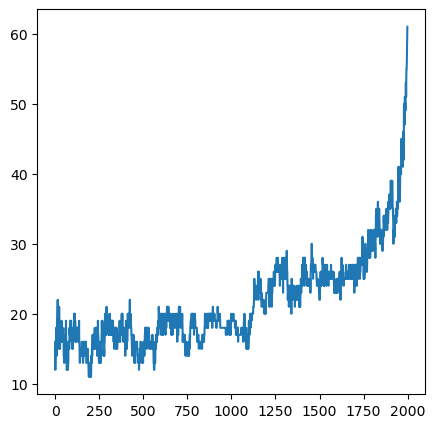

In [42]:
# Quantify fine-ness
point_counts = []
for s in tqdm(simplices_list):
    unique_points = np.unique(s.flatten())
    point_counts.append(len(unique_points))

plt.figure(figsize=(5,5))
plt.plot(point_counts)

In [33]:
# Create gif
from PIL import Image
images = []
num_images = 200
stepsize = int(num_timesteps/num_images)
for t in range(0, num_timesteps):
    if t % stepsize == 0:
        plt_figure = plt.figure(figsize=(5,5))
        Plot_2D_Triangulation(points_list[t], simplices_list[t])
        plt_figure.canvas.draw()
        image = Image.frombytes('RGB',plt_figure.canvas.get_width_height(),plt_figure.canvas.tostring_rgb())
        images.append(image)
        plt.close()
images[0].save(gif_dir + '/triangulations.gif', save_all=True, append_images=images[1:], duration=50)

/tmp/ipykernel_4116312/3859874023.py:11: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = Image.frombytes('RGB',plt_figure.canvas.get_width_height(),plt_figure.canvas.tostring_rgb())
